# LAT Thermal Control Plots

### Robert Cameron, September 2015

In [1]:
from astropy.table import Table, Column
import numpy as np
from os.path import expanduser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
%matplotlib inline

In [2]:
# read regular ASCII tabular file of Fermi navigation history

HOME = expanduser("~/Documents/GLAST/ISOC/LATmetrics")
navfile = HOME+"/beta/nav.history"
navtab = Table.read(navfile, format='ascii',names=('ymd','hms','s1970','x','y','z','vx','vy','vz'))
ymd = navtab['ymd']
hms = navtab['hms']
s1970 = navtab['s1970']
x = navtab['x']
y = navtab['y']
z = navtab['z']
vx = navtab['vx']
vy = navtab['vy']
vz = navtab['vz']
d1970 = s1970/86400.0
JD = d1970 + 2440587.5
DJ2000 = JD - 2451545.0
yr = DJ2000/365.25 + 2000.0

In [3]:
# caculate beta angle from Fermi navigation history
# use Sun position calculations from http://aa.usno.navy.mil/faq/docs/SunApprox.php

g = np.radians(357.529 + 0.98560028 * DJ2000)    # g = mean anomaly of the Sun
q = 280.459 + 0.98564736 * DJ2000  # q = mean longitude of the Sun, in degrees
L = np.radians(q + 1.915 * np.sin(g) + 0.020 * np.sin(2*g)) # L = geocentric apparent ecliptic longitude of the Sun, adjusted for aberration
rAU = 1.00014 - 0.01671 * np.cos(g) - 0.00014 * np.cos(2*g)  # rAU = Sun-Earth distance in AU
e = np.radians(23.439 - 0.00000036 * DJ2000)  # e = mean obliquity of the ecliptic

# get Sun's RA and Dec
tanRA = np.cos(e) * np.tan(L)
Zsun = np.sin(e) * np.sin(L)
sun_Dec = np.arcsin(Zsun)
sun_RA = np.arctan(np.cos(e) * np.sin(L),np.cos(L))
Xsun = np.cos(sun_Dec) * np.cos(sun_RA)
Ysun = np.cos(sun_Dec) * np.sin(sun_RA)

# normalize the Fermi position and velocity vectors
pos = np.sqrt(x*x + y*y + z*z)
vel = np.sqrt(vx*vx + vy*vy + vz*vz)
xn = x/pos
yn = y/pos
zn = z/pos
vxn = vx/vel
vyn = vy/vel
vzn = vz/vel

# get the vector to the Fermi orbit pole from the cross product of the Fermi position and velocity vectors
Polex = yn*vzn - zn*vyn
Poley = zn*vxn - xn*vzn
Polez = xn*vyn - yn*vxn

# calculate angle between Sun Vector and Fermi orbit pole, using dot product
# NOTE: beta angle is the complement of the angle from the dot product, so use sin instead of cos
sinbeta = Xsun*Polex + Ysun*Poley + Zsun*Polez
beta = np.degrees(np.arcsin(sinbeta))

In [4]:
doyformat = "%j"
doy = [dt.datetime.strptime(ymd[i],"%Y-%m-%d").timetuple().tm_yday for i in range(len(ymd))]
dnt = [dt.datetime.strptime(ymd[i]+hms[i],"%Y-%m-%d%H:%M:%S") for i in range(len(ymd))]

In [5]:
# read irregular ASCII tabular file of history of VCHP control

htrfile = HOME+"/LTC/htr.history"
df = pd.read_csv(htrfile, parse_dates=[1], delimiter="\t",header=None)
(hymd,tot0,off0,tot6,off6,tot7,off7) = (df[0],df[2],df[3],df[5],df[6],df[8],df[9])

ok = (tot0 > 0) & (tot6 > 0) & (tot7 > 0)

hymd = hymd[ok]
tot0 = tot0[ok]
off0 = off0[ok]
tot6 = tot6[ok]
off6 = off6[ok]
tot7 = tot7[ok]
off7 = off7[ok]
f0 = off0/tot0
f6 = off6/tot6
f7 = off7/tot7
#VCHP0 = 1-pd.rolling_window(f0,20,win_type='boxcar',center=True)
#VCHP6 = 1-pd.rolling_window(f6,20,win_type='boxcar',center=True)
#VCHP7 = 1-pd.rolling_window(f7,20,win_type='boxcar',center=True)

VCHP0 = 1-pd.Series.rolling(f0,axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP6 = 1-pd.Series.rolling(f6,axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP7 = 1-pd.Series.rolling(f7,axis=0,window=20,win_type='boxcar',center=True).mean()

fx = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in hymd]

Text(0,0.5,'Beta angle (deg)')

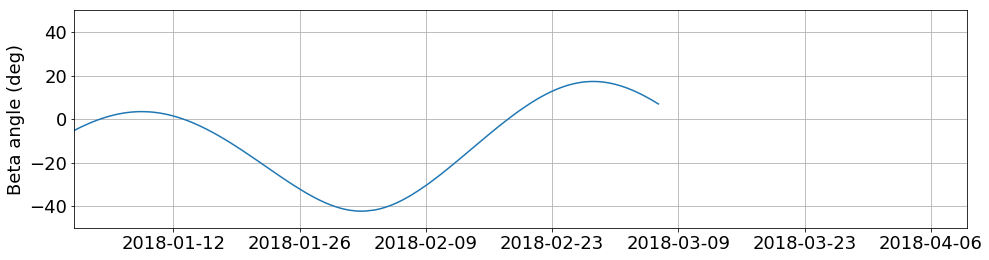

In [6]:
plt.figure(figsize = [16, 4])
plt.rc('font', size = 18)
dntmin="2018-01-01 00:00:00"
dntmax="2018-04-10 00:00:00"
dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")
plt.xlim(dnt0,dnt1)
plt.plot(dnt,beta)
plt.ylim([-50.0,50.0])
plt.grid(True)
plt.ylabel('Beta angle (deg)')

Text(0,0.5,'VCHP On Fraction')

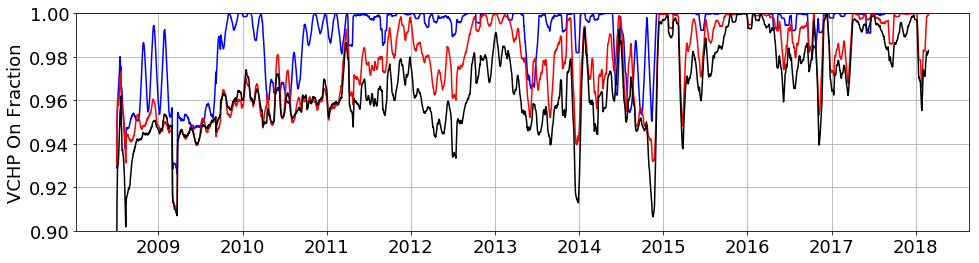

In [7]:
plt.figure(figsize = [16, 4])
plt.rc('font', size = 18)

plt.plot(fx,VCHP0,'-b',label='VCHP0')
plt.plot(fx,VCHP6,'-r',label='VCHP6')
plt.plot(fx,VCHP7,'-k',label='VCHP7')
plt.grid(True)
#ax2.set_xlim(datemin, datemax)
plt.ylim(0.9,1.0)
#ax2.legend(loc='lower center',fontsize='small')
plt.ylabel('VCHP Conductance Duty Cycle')
plt.ylabel('VCHP On Fraction')
#captionx = dt.date(2010,1,15)
#captionx = dt.date(2010,1,15)
#captionx = 0.1
#plt.text(captionx,0.932,"VCHP 0",color='b',fontsize='large')
#plt.text(captionx,0.922,"VCHP 6",color='r',fontsize='large')
#plt.text(captionx,0.912,"VCHP 7",color='k',fontsize='large')
#print(fx)

Text(0,0.5,'Earth-Sun Distance (AU)')

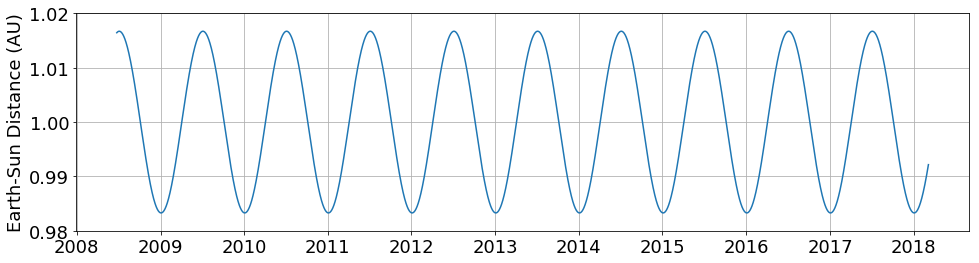

In [8]:
plt.figure(figsize = [16, 4])
plt.rc('font', size = 18)

plt.plot(dnt, rAU)
plt.grid(True)
#plt.xaxis.set_minor_locator(months)
plt.ylim(0.98, 1.02)
plt.ylabel('Earth-Sun Distance (AU)')